# N-qubit GHZ distillation protocols

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sy
from numpy.linalg import multi_dot
from google.colab import files
from itertools import product
import functools as ft

%matplotlib inline

## Utilizing gate-decomposition of the unitary operations for arbitrary no. parties

In [2]:
# Define Pauli matrix sigma_0
sigma_0 = np.array([[1, 0], [0, 1]])

# Define |0X0| measurement matrix
M0 = np.outer([1, 0], np.conjugate([1, 0]))

# Define |1X1| measurement matrix
M1 = np.outer([0, 1], np.conjugate([0, 1]))

def make_measurement_matrix(N, mea='0'):
  # N Number of parties
  # nq Number of qubits
  # mea desired measurement result on ancillary qubits -> possible inputs: 0/1; default mea='0'
  nq = 2*N
  if mea=='0':
    matrices = [sigma_0 if i % 2 == 0 else M0 for i in range(nq)]
    result = ft.reduce(np.kron, matrices)
  elif mea=='1':
    matrices = [sigma_0 if i % 2 == 0 else M1 for i in range(nq)]
    result = ft.reduce(np.kron, matrices)
  return result

In [3]:
S0 = np.array([1, 0])
S1 = np.array([0, 1])

def make_GHZ(nq):
  # nq Number of qubits
  listS0 = [S0 for _ in range(nq)]
  listS1 = [S1 for _ in range(nq)]
  GHZ = ft.reduce(np.kron, listS0).flatten()/ np.sqrt(2) + ft.reduce(np.kron, listS1).flatten() / np.sqrt(2)
  return GHZ

def make_GHZl(nq, c):
  # nq Number of qubits
  listS0 = [S0 for _ in range(nq)]
  listS1 = [S1 for _ in range(nq)]
  GHZl = ft.reduce(np.kron, listS0).flatten() + c * ft.reduce(np.kron, listS1).flatten()
  return GHZl / np.linalg.norm(GHZl)

In [4]:
from scipy.sparse import csr_matrix

def make_rho_GHZ(rho):
  # Compute the outer product of GHZ and its conjugate
  return np.outer(rho, np.conjugate(rho))

# Convert the rho_GHZ to a sparse matrix
# rho_GHZ_sparse = csr_matrix(rho_GHZ)

In [5]:
#from scipy.sparse import identity

def make_noisy_rho(rho_GHZ, nq, lambda_val):
  ''' Calculate noisy initial density matrix'''
  # lambda_val noise strength
  d = 2**nq # dimension
  rho_noisy = (1 - lambda_val) * rho_GHZ + lambda_val / d * np.identity(d)
  return rho_noisy

In [6]:
def make_noisy_rho_I2(rho_GHZ, nq, lambda_val):
  ''' Calculate noisy initial density matrix'''
  # lambda_val noise strength
  M = np.zeros((2**nq, 2**nq), dtype=float)
  M[0, 0] = 1
  M[-1, -1] = 1
  rho_noisy = (1 - lambda_val) * rho_GHZ + lambda_val / 2 * M
  return rho_noisy

In [7]:
# 2) computational basis projectors |000><000| and |111><111|
zero = np.kron(np.kron(S0, S0), S0)  # S0 = [1,0]
one  = np.kron(np.kron(S1, S1), S1)  # S1 = [0,1]
P000 = np.outer(zero, zero.conj())
P111 = np.outer(one,  one.conj())

In [8]:
listS0 = [S0 for _ in range(3)]
listS1 = [S1 for _ in range(3)]
zero = ft.reduce(np.kron, listS0).flatten()
one = ft.reduce(np.kron, listS1).flatten()
P000 = np.outer(zero, zero.conj())
P111 = np.outer(one,  one.conj())
P000+P111

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])

In [9]:
#traceing out the ancillary qubits in non-transformed basis
def partial_trace_g(rho, N):
  ''' partial trace of rho(2^2n_x_2^2n), qubits: q0,q1,q2,q3,q4,q5,...qn-1
      tracing out last n/2 qubits, resulting in rho(2^n_x_2^n)
  '''
  # N number of ancillary qubit
  rho_traced = rho.reshape([2 for _ in range(2*2*N)])
  for i in range(N):
    rho_traced = np.trace(rho_traced, axis1=N, axis2=3*N-i)
  return rho_traced.reshape([2**N, 2**N])

In [10]:
# Define CNOT matrix - CNOT(index-of-control-qubit, index-of-target-qubit, number-of-parties)

def CNOT(i, j, N):
    # N No. parties
    nq = 2*N # No. qubits
    basis = list(product([0, 1], repeat=nq))
    basis = [list(i) for i in basis]

    def CNOTket(i, j, lst):
        output = list(lst)
        if lst[i] == 0:
            return output
        else:
            output[j] = 1 - output[j]
            return output

    def cnot(i,j):
        #index i,j: 0...nq-1
        mtx = np.zeros((2**nq, 2**nq))
        pos = []
        for n in range(len(basis)):
            pos.append([n, basis.index(CNOTket(i,j,basis[n]))])
        for i, j in pos:
            mtx[i][j] = 1
        return(mtx)

    return cnot(i, j)

In [11]:
# Gate decomposition of unitary matrices

# Define Pauli matrix sigma_1
sigma_1 = np.array([[0, 1], [1, 0]])

# Hadamard gate
h = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])

# Rz(pi/6) gate
rz6 = np.array([[1, 0],[0, np.exp(1j*np.pi/3)]])

def make_decomposed_CXX(N):
  # N Number of parties
  xxx = ft.reduce(np.kron, [sigma_0 for i in range(N)] + [sigma_1 for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return np.dot(xxx, matrix)

def make_decomposed_CXH(N):
  # N Number of parties
  had = ft.reduce(np.kron, [sigma_0 for i in range(N)] + [h for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i+N, i, N))
  return np.dot(had, matrix)

def make_trained_U(N):
  # Pre-trained unitary
  # N Number of parties
  rzhrz = ft.reduce(np.kron, [multi_dot([rz6, h, rz6]) for i in range(N)] + [sigma_0 for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return np.dot(rzhrz, matrix)

def make_simplified_U(N):
  # Tamas' old protocol
  # N Number of parties
  had = ft.reduce(np.kron, [h for i in range(N)] + [sigma_0 for i in range(N)])
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return np.dot(had, matrix)

In [12]:
def make_measurement_matrix_gate(N, mea='0'):
  '''measurement projectors in non-transformed basis'''
  # N Number of parties; nq Number of qubits
  # mea desired measurement result on ancillary qubits -> possible inputs: 0/1; default mea='0'
  nq = 2*N
  if mea=='0':
    matrices = [sigma_0 for i in range(N)] + [M0 for i in range(N)]
    result = ft.reduce(np.kron, matrices)
  elif mea=='1':
    matrices = [sigma_0 for i in range(N)] + [M1 for i in range(N)]
    result = ft.reduce(np.kron, matrices)
  return result

In [13]:
def prot_gate(rho0, U, N, mea='0'):
        ''' Evaluate the protocol: LOCC + mid-circuit measurements |0X0| or |1X1|'''
        # N number of ancillary qubit/ no. parties
        # Initial density matrix |GHZ>x|GHZ_copy>
        rho = np.kron(rho0, rho0)

        # Compute density matrix evolution according to the protocol in non-transformed basis |q0,q1,q2...qn-1>
        left = multi_dot([make_measurement_matrix_gate(N, mea), U])
        right = np.matrix.getH(multi_dot([make_measurement_matrix_gate(N, mea), U]))
        rho_prime = multi_dot([left, rho, right])

        # Return with traced-out density matrix
        return partial_trace_g(rho_prime, N)

In [14]:
def alternating_scheme_g(rho0, N, n):
    ''' Apply prot_rho recursively n times while exchanging unitary matrices in every iteration'''
    result = rho0
    matrix_cxx = make_decomposed_CXX(N)
    matrix_cxh = make_decomposed_CXH(N)
    for i in range(n):
         result = prot_gate(result, matrix_cxx if i % 2 == 0 else matrix_cxh, N)
         result = result / np.trace(result) # Normalize
    return result

In [15]:
#Special case considering alternating distillation criteria (for referee)
def alternating_scheme_alt_crit(rho0, N, n):
    """
    Apply prot_gate recursively n times, alternating
    both the unitary (CXX/CXH) and the measurement (M0/M1).
    """
    rho = rho0
    matrix_cxx = make_decomposed_CXX(N)
    matrix_cxh = make_decomposed_CXH(N)

    for i in range(n):
        # choose unitary
        U   = matrix_cxx if (i % 2 == 0) else matrix_cxh
        # alternate measurement outcome: '0'→M0 on even, '1'→M1 on odd
        mea = '0' if (i % 2 == 0) else '1'

        # apply one round and normalize
        rho = prot_gate(rho, U, N, mea)
        rho = rho / np.trace(rho)

    return rho


In [16]:
#Special case: Non-Identical Copies as Input (for referee)
def prot_gate_distinct_copies(rho1, rho2, U, N, mea='0'):
    """
    One round of the LOCC + mid-circuit measurement protocol,
    where rho1 and rho2 are two distinct input registers.

    Parameters
    ----------
    rho1 : np.ndarray
        The N-qubit “system” density matrix (shape 2^N × 2^N).
    rho2 : np.ndarray
        The N-qubit “ancilla” density matrix (shape 2^N × 2^N).
    U : np.ndarray
        The 2N-qubit unitary to apply before measurement.
    N : int
        Number of ancilla qubits (and parties).
    mea : {'0','1'}
        Which projector to use on the ancilla: '0'→M0, '1'→M1.

    Returns
    -------
    np.ndarray
        The post-measurement system density matrix
        (ancillas are traced out).
    """
    # build the 2N-qubit input
    rho_combined = np.kron(rho1, rho2)

    # pick & apply the projector + unitary
    P     = make_measurement_matrix_gate(N, mea)
    left  = P @ U
    right = left.conj().T
    rho_p = left @ rho_combined @ right

    # trace out the last N qubits (ancilla) → back to an N-qubit system
    return partial_trace_g(rho_p, N)


def alternating_scheme_distinct_copies(rho1, rho2, N, n):
    """
    Apply `prot_gate` n times, alternating CXX/CXH and M0/M1.
    - On the first iteration, use (rho1, rho2).
    - On subsequent iterations, use (rho_prev, rho_prev) for both inputs.
    """
    rho_sys = rho1.copy()
    U_even  = make_decomposed_CXX(N)
    U_odd   = make_decomposed_CXH(N)

    for i in range(n):
        # pick unitary and measurement outcome
        U   = U_even if (i % 2 == 0) else U_odd
        mea = '0'    if (i % 2 == 0) else '0'

        if i == 0:
            # first round: system=rho1, ancilla=rho2
            rho_sys = prot_gate_distinct_copies(rho_sys, rho2, U, N, mea)
        else:
            # further rounds:
            # 1 - feed back the evolved state for both regs - set rho_sys as ancilla
            # 2 - use a fresh ancilla - set rho2
            rho_sys = prot_gate_distinct_copies(rho_sys, rho_sys, U, N, mea)

        # normalize by trace to keep a valid density matrix
        rho_sys = rho_sys / np.trace(rho_sys)

    return rho_sys


In [17]:
def uniform_scheme_g(rho0, N, n, mx='0'):
    ''' Apply prot_rho recursively n times while exploiting pre-trained or simplified unitary matrix'''
     # mx desired unitary gate -> possible inputs: 0/1; 0: trained; 1: simplified; default mx='0'
    result = rho0
    matrix_train = make_trained_U(N)
    matrix_simple = make_simplified_U(N)
    for i in range(n):
         result = prot_gate(result, matrix_simple if mx == '0' else matrix_train, N)
         result = result / np.trace(result) # Normalize
    return result

In [18]:
#Special case considering alternating distillation criteria (for referee)
def uniform_scheme_alt_crit(rho0, N, n, mx='0'):
    """
    Apply prot_gate recursively n times using either the pre-trained
    or simplified unitary, and alternate measurement M0/M1 each round.

    Parameters
    ----------
    rho0 : np.ndarray
        Initial N-party density matrix.
    N : int
        Number of ancillary qubits/parties.
    n : int
        Number of iterations.
    mx : {'0','1'}
        Which unitary to use every round: '0' = trained U, '1' = simplified U.
    """
    rho = rho0
    U_train  = make_trained_U(N)
    U_simple = make_simplified_U(N)

    # pick the fixed unitary once
    U = U_train if mx == '0' else U_simple

    for i in range(n):
        # alternate measurement outcome each iteration
        mea = '1' if (i % 2 == 0) else '0'

        # apply one round with U and M0/M1
        rho = prot_gate(rho, U, N, mea)

        # normalize by trace
        rho = rho / np.trace(rho)

    return rho


In [19]:
# adaptive distillation rather than the static-copy model
# since protocol doesn't require identical copies we can use a freshly generate noisy input as an ancilla
def uniform_scheme_distinct_copies(rho1, rho2, N, n, mx='0'):
    """
    Apply `prot_gate` n times using a fixed unitary (trained vs simplified),
    alternating measurement M0/M1 each round is possible (set it manually), and after the first iteration
    always re-using the freshly generated noisy state for the ancilla input.

    Parameters
    ----------
    rho1 : np.ndarray
        Initial “system” density matrix (2^N × 2^N).
    rho2 : np.ndarray
        Initial “ancilla” density matrix (2^N × 2^N).
    N : int
        Number of ancilla qubits/parties.
    n : int
        Number of iterations.
    mx : {'0','1'}
        Which unitary to use:
        '0' = pre-trained U; '1' = simplified U.
    """
    # pick the fixed unitary once
    U_train  = make_trained_U(N)
    U_simple = make_simplified_U(N)
    U = U_train if mx == '0' else U_simple

    rho_sys = rho1.copy()

    for i in range(n):
        mea = '0' if (i % 2 == 0) else '0'

        if i == 0:
            # first round: use (rho1, rho2)
            rho_sys = prot_gate_distinct_copies(rho_sys, rho2, U, N, mea)
        else:
            # subsequent rounds:
            # 1 - feed back the evolved state for both regs - set rho_sys as ancilla
            # 2 - use a fresh ancilla - set rho2
            rho_sys = prot_gate_distinct_copies(rho_sys, rho2, U, N, mea)

        # keep it a valid density matrix
        rho_sys = rho_sys / np.trace(rho_sys)

    return rho_sys


In [20]:
def uniform_simp(rho0, N, n):
    ''' Apply prot_rho recursively n times with fixed unitary matrices in every iteration'''
    result = rho0
    matrix_simple = make_simplified_U(N)
    for i in range(n):
         result = prot_gate(result, matrix_simple, N)
         result = result / np.trace(result) # Normalize
    return result

In [21]:
def uniform_trained(rho0, N, n):
    ''' Apply prot_rho recursively n times with fixed unitary matrices in every iteration'''
    result = rho0
    matrix_train = make_trained_U(N)
    for i in range(n):
         result = prot_gate(result, matrix_train, N)
         result = result / np.trace(result) # Normalize
    return result

In [22]:
# Define fidelity function
def fidelity(our_state, target):
  return multi_dot([np.conjugate(target), our_state, target])

## Results for 3-Qubit Distillation Protocols

### Protocols and Noise Model
- **Alternating vs. Uniform Gate Sequences**  
  Compare performance when applying gates in an alternating pattern versus a fixed (“uniform”) pattern.
- **White-Noise Decoherence**  
  Initial GHZ state subjected to white noise admixture, parameterized by strength λ.

### Performance Metrics
- **Fidelity vs. Iteration**  
  How the output fidelity F improves as you increase the number of distillation iterations n.
- **Dependence on Noise Strength**  
  Plot F(n) for several λ values to see robustness under different noise levels.
- **Effect of Non-Identical Input Copies**  
  Analyze cases where the two input noisy GHZ states have different noise parameters—plot F(n) when λ₁ ≠ λ₂ to see how mismatch affects distillation.

In [ ]:
noq = 3
lam = 0.05
GHZ = make_GHZ(noq)
GHZl = make_GHZl(noq, 1.1)
rho_GHZ = make_rho_GHZ(GHZ)
rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)

noi = 8 #No. iteration
iter_data = list(range(noi))
fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]
fid_data2 = [fidelity(uniform_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]

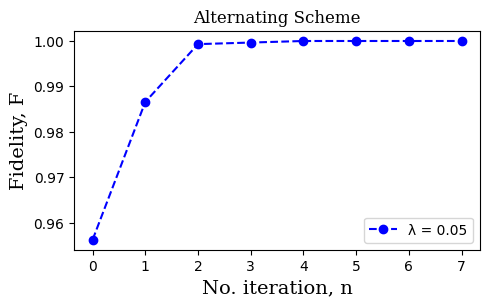

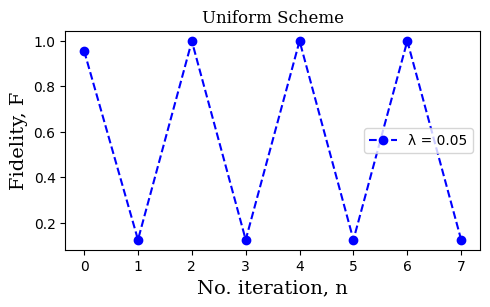

In [ ]:
# Alternating Scheme
plt.figure(figsize=(5, 3))
plt.plot(iter_data, fid_data, 'o--b', label=f'λ = {lam}')
plt.xlabel('No. iteration, n', fontname='serif')
plt.ylabel('Fidelity, F', fontname='serif')
plt.title('Alternating Scheme', fontname='serif')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# Uniform Scheme
plt.figure(figsize=(5, 3))
plt.plot(iter_data[0::1], fid_data2[0::1], 'o--b', label=f'λ = {lam}')
plt.xlabel('No. iteration, n', fontname='serif')
plt.ylabel('Fidelity, F', fontname='serif')
plt.title('Uniform Scheme', fontname='serif')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
#plt.savefig('uniform-iter.pdf')
#files.download("uniform-iter.pdf")
plt.show()

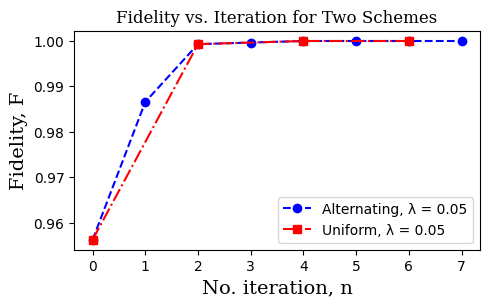

In [ ]:
plt.figure(figsize=(5, 3))

# Alternating scheme curve
plt.plot(iter_data,
         fid_data,
         marker='o',
         linestyle='--',
         color='blue',
         label=f'Alternating, λ = {lam}')

# Uniform scheme curve
plt.plot(iter_data[0::2],
         fid_data2[0::2],
         marker='s',
         linestyle='-.',
         color='red',
         label=f'Uniform, λ = {lam}')

# Labels & title
plt.xlabel('No. iteration, n', fontname='serif')
plt.ylabel('Fidelity, F', fontname='serif')
plt.title('Fidelity vs. Iteration for Two Schemes', fontname='serif')

# Legend & ticks
plt.legend()
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Layout tweaks
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()

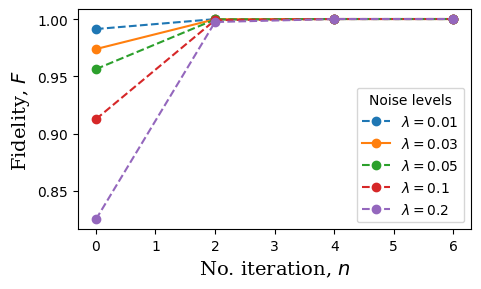

In [ ]:
noq    = 3
GHZ    = make_GHZ(noq)
GHZl   = make_GHZl(noq, 1.1)
rho_GHZ= make_rho_GHZ(GHZ)
rho_noisy = make_noisy_rho(rho_GHZ, noq, 0.03)

# list of λ values to sweep
lam_list = [0.01, 0.03, 0.05, 0.1, 0.2]

noi     = 8  # number of iterations to plot
iter_data = list(range(noi))

xfont = {'fontname':'serif'}

plt.figure(figsize=(5,3))

for idx, lam in enumerate(lam_list):
    # build noisy initial rho for this lambda
    rho_noisy_2 = make_noisy_rho(rho_GHZ, noq, lam)

    '''compute fidelity after each round of the alternating protocol'''
    fid_data = [
        fidelity(
            alternating_scheme_distinct_copies(rho_noisy_2, rho_noisy, noq, i),
            GHZ
        )
        for i in iter_data
    ]

    '''compute fidelity after each round of the uniform protocol'''
    #fid_data = [
    #    fidelity(
    #        uniform_scheme_distinct_copies(rho_noisy_2, rho_noisy, noq, i),
    #        GHZ
    #    )
    #    for i in iter_data
    #]

    # choose solid linestyle for the second curve (idx==1), dashed otherwise
    ls = '-' if idx == 1 else '--'

    plt.plot(iter_data[0::2], fid_data[0::2], marker='o', linestyle=ls,
             label=fr'$\lambda={lam}$')

plt.xlabel('No. iteration, $n$', **xfont)
plt.ylabel('Fidelity, $F$', **xfont)
plt.legend(title='Noise levels', fontsize=10)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.tight_layout()
#plt.savefig('diff_replicas_uni.pdf')
#files.download("diff_replicas_uni.pdf")
plt.show()


In [ ]:
protocol_list = []

noq = 3 #No. qubits
noi = 10 #No. iteration
iter_data = list(range(noi))
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
for lam in np.arange(0.0, 1.2, 0.2):
  rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)
  #fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]  #Alternating scheme
  fid_data = [fidelity(uniform_trained(rho_noisy, noq, i), GHZ) for i in range(noi)]        #Uniform scheme
  protocol_list += [fid_data]

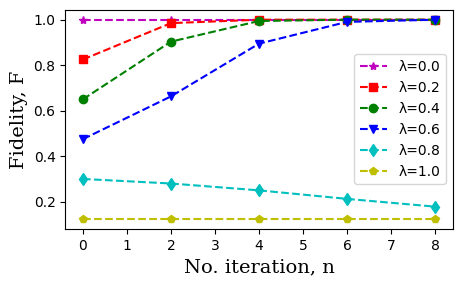

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='λ=0.0')
ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='λ=0.2')
ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='λ=0.4')
ax.plot(iter_data[0::2], protocol_list[3][0::2], 'v--b', label='λ=0.6')
ax.plot(iter_data[0::2], protocol_list[4][0::2], 'd--c', label='λ=0.8')
ax.plot(iter_data[0::2], protocol_list[5][0::2], 'p--y', label='λ=1.0')
ax.legend()
plt.xlabel('No. iteration, n', **xfont)
plt.ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()

## Generalization as N-Qubit Protocol

### Protocol Extension
- **Arbitrary N-Qubit Distillation**  
  Investigate the extension of alternating and uniform gate sequences to GHZ states of arbitrary size N.

### Performance Metrics
- **Fidelity vs. Iteration for Different N**  
  Plot F(n) for various system sizes (e.g., N = 3, 4, 5…) to evaluate how the protocol scales.

### Noise Models
- **I₂ White Noise (GHZ Subspace Only)**  
  White-noise admixture confined to the 2-dimensional GHZ subspace.  
- **I₈ White Noise (Full Hilbert Space)**  
  Uniform white-noise admixture across the entire 2ᴺ-dimensional space.

### Conclusion
- *This scheme can be easily adopted to an arbitrary number of qubits (parties).*


In [ ]:
protocol_list = []
protocol_list_2 = []

lam = 0.3 #Noise strength
noi = 12 #No. iteration
iter_data = list(range(noi))

for noq in [2,3,4,5]:
  GHZ = make_GHZ(noq)
  rho_GHZ = make_rho_GHZ(GHZ)
  rho_noisy = make_noisy_rho_I2(rho_GHZ, noq, lam)
  fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]
  fid_data_2 = [fidelity(uniform_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]
  protocol_list += [fid_data]
  protocol_list_2 += [fid_data_2]

In [ ]:
make_noisy_rho_I2(make_rho_GHZ(make_GHZ(2)), 2, 1.)

array([[0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5]])

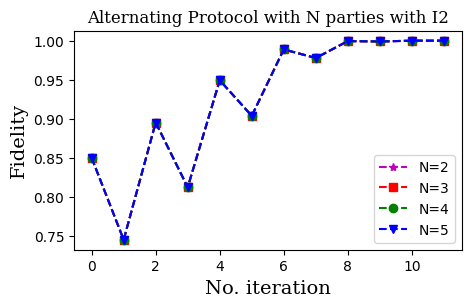

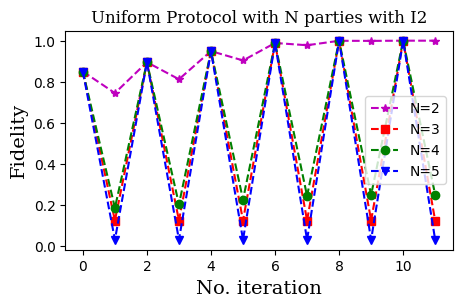

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data, protocol_list[0], '*--m', label='N=2')
ax.plot(iter_data, protocol_list[1], 's--r', label='N=3')
ax.plot(iter_data, protocol_list[2], 'o--g', label='N=4')
ax.plot(iter_data, protocol_list[3], 'v--b', label='N=5')
ax.legend()
ax.set_xlabel('No. iteration', **xfont)
ax.set_ylabel('Fidelity', **xfont)
ax.set_title('Alternating Protocol with N parties with I2', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
# alternate option without .gcf
plt.subplots_adjust(bottom=0.15)
#fig.savefig('nparty-alt-I2.png')
#files.download("nparty-alt-I2.png")
plt.show()

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data, protocol_list_2[0], '*--m', label='N=2')
ax.plot(iter_data, protocol_list_2[1], 's--r', label='N=3')
ax.plot(iter_data, protocol_list_2[2], 'o--g', label='N=4')
ax.plot(iter_data, protocol_list_2[3], 'v--b', label='N=5')
ax.legend()
ax.set_xlabel('No. iteration', **xfont)
ax.set_ylabel('Fidelity', **xfont)
ax.set_title('Uniform Protocol with N parties with I2', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
# alternate option without .gcf
plt.subplots_adjust(bottom=0.15)
#fig.savefig('nparty-uni-I2.png')
#files.download("nparty-uni-I2.png")
plt.show()

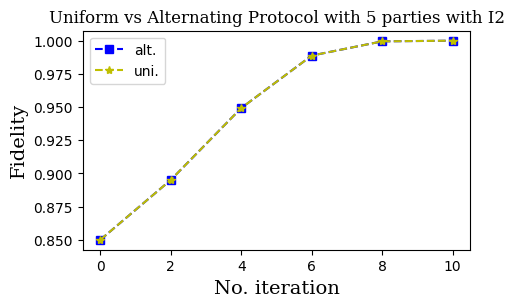

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list[3][0::2], 's--b', label='alt.')
ax.plot(iter_data[0::2], protocol_list_2[3][0::2], '*--y', label='uni.')
ax.legend()
ax.set_xlabel('No. iteration', **xfont)
ax.set_ylabel('Fidelity', **xfont)
ax.set_title('Uniform vs Alternating Protocol with 5 parties with I2', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
# alternate option without .gcf
plt.subplots_adjust(bottom=0.15)
#fig.savefig('nparty-uni-I2.png')
#files.download("nparty-uni-I2.png")
plt.show()

 **Initial Fidelity vs. Number of Qubits under I₈ Noise**

As we increase the number of qubits _N_, the initial fidelity _F₀_ drops — reflecting greater vulnerability to white-noise admixture _I₈_ — until it levels off asymptotically converges to a fixed value, where further increases in N no longer degrade the fidelity.

In [ ]:
f_list = []
lam = 0.3 #Noise strength

for noq in range(2,10):
  GHZ = make_GHZ(noq)
  rho_GHZ = make_rho_GHZ(GHZ)
  rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)
  fid_data = fidelity(rho_noisy, GHZ)
  f_list += [fid_data]

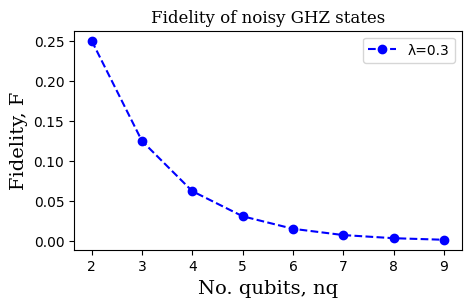

In [ ]:
xfont = {'fontname':'serif'}

f = plt.figure(figsize=(5,3))
plt.plot(range(2,10), f_list, 'o--b', label='λ=0.3')
plt.xlabel('No. qubits, nq', **xfont)
plt.ylabel('Fidelity, F', **xfont)
plt.title('Fidelity of noisy GHZ states', **xfont)
# draw the legend
plt.legend(loc='best', fontsize=10)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#plt.savefig('fidelity-nq.png')
#files.download("fidelity-nq.png")
plt.show()

In [ ]:
protocol_list = []
protocol_list_2 = []

lam = 0.3 #Noise strength
noi = 8 #No. iteration
iter_data = list(range(noi))

for noq in [2,3,4,5]:
  GHZ = make_GHZ(noq)
  rho_GHZ = make_rho_GHZ(GHZ)
  rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)
  fid_data = [fidelity(alternating_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]
  fid_data_2 = [fidelity(uniform_trained(rho_noisy, noq, i), GHZ) for i in range(noi)]
  protocol_list += [fid_data]
  protocol_list_2 += [fid_data_2]

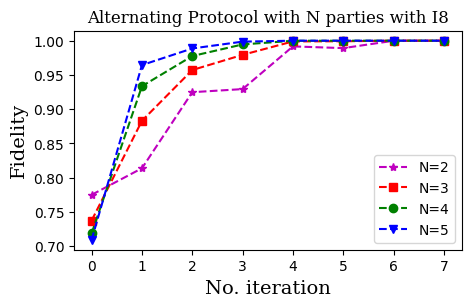

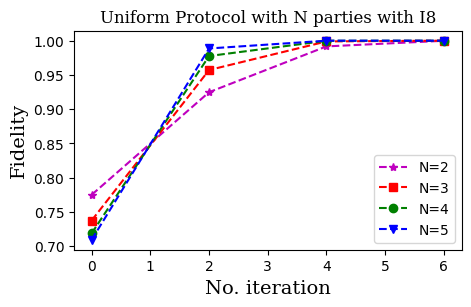

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data, protocol_list[0], '*--m', label='N=2')
ax.plot(iter_data, protocol_list[1], 's--r', label='N=3')
ax.plot(iter_data, protocol_list[2], 'o--g', label='N=4')
ax.plot(iter_data, protocol_list[3], 'v--b', label='N=5')
ax.legend()
ax.set_xlabel('No. iteration', **xfont)
ax.set_ylabel('Fidelity', **xfont)
ax.set_title('Alternating Protocol with N parties with I8', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
# alternate option without .gcf
plt.subplots_adjust(bottom=0.15)
#fig.savefig('nparty-alt-I8.png')
#files.download("nparty-alt-I8.png")
plt.show()

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list_2[0][0::2], '*--m', label='N=2')
ax.plot(iter_data[0::2], protocol_list_2[1][0::2], 's--r', label='N=3')
ax.plot(iter_data[0::2], protocol_list_2[2][0::2], 'o--g', label='N=4')
ax.plot(iter_data[0::2], protocol_list_2[3][0::2], 'v--b', label='N=5')
ax.legend()
ax.set_xlabel('No. iteration', **xfont)
ax.set_ylabel('Fidelity', **xfont)
ax.set_title('Uniform Protocol with N parties with I8', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
# alternate option without .gcf
plt.subplots_adjust(bottom=0.15)
#fig.savefig('nparty-uni-I8.png')
#files.download("nparty-uni-I8.png")
plt.show()

**Uniform pre-trained protocol for N-qubit:** <br>
*conclusion:* this scheme cannot be extended for arbitrary number of qubits (parties)

In [ ]:
protocol_list = []

lam = 0.3 #Noise strength
noi = 8 #No. iteration
iter_data = list(range(noi))

for noq in [2,3,4,5]:
  GHZ = make_GHZ(noq)
  rho_GHZ = make_rho_GHZ(GHZ)
  rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)
  fid_data = [fidelity(uniform_simp(rho_noisy, noq, i), GHZ) for i in range(noi)]
  protocol_list += [fid_data]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


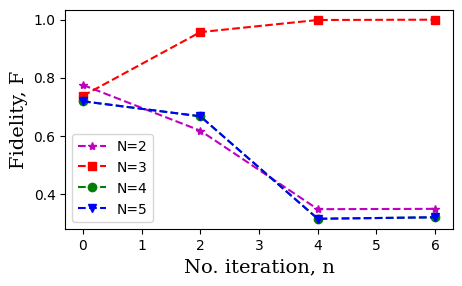

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='N=2')
ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='N=3')
ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='N=4')
ax.plot(iter_data[0::2], protocol_list[2][0::2], 'v--b', label='N=5')

ax.legend()
ax.set_xlabel('No. iteration, n', **xfont)
ax.set_ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()

**Bennett's protocol extension for N-qubit:** <br>
*conclusion:* this scheme cannot be extended for arbitrary number of qubits (parties)

In [ ]:
def make_bennett_U(N):
  # N Number of parties
  matrix = np.identity(2**(2*N))
  for i in range(N):
    matrix = np.dot(matrix, CNOT(i, i+N, N))
  return matrix

In [ ]:
def Bennett_scheme(rho0, N, n):
    ''' Apply prot_rho recursively n times while exchanging unitary matrices in every iteration'''
    result = rho0
    matrix_bennett = make_bennett_U(N)
    for i in range(n):
         result = prot_gate(result, matrix_bennett, N)
         result = result / np.trace(result) # Normalize
    return result

In [ ]:
protocol_list = []

noq = 2 #No. qubits
noi = 10 #No. iteration
iter_data = list(range(noi))
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
for lam in np.arange(0.0, 1.2, 0.2):
  rho_noisy = make_noisy_rho(rho_GHZ, noq, lam)
  fid_data = [fidelity(Bennett_scheme(rho_noisy, noq, i), GHZ) for i in range(noi)]        #Bennett's scheme
  protocol_list += [fid_data]

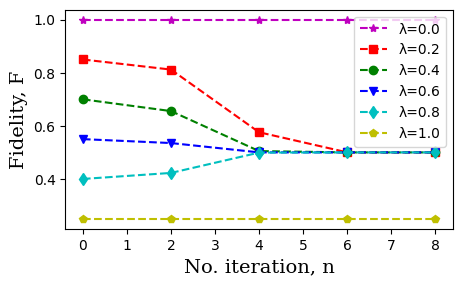

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='λ=0.0')
ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='λ=0.2')
ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='λ=0.4')
ax.plot(iter_data[0::2], protocol_list[3][0::2], 'v--b', label='λ=0.6')
ax.plot(iter_data[0::2], protocol_list[4][0::2], 'd--c', label='λ=0.8')
ax.plot(iter_data[0::2], protocol_list[5][0::2], 'p--y', label='λ=1.0')
ax.legend()
plt.xlabel('No. iteration, n', **xfont)
plt.ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()

## Arbitrary noise for N protocol

In [ ]:
def make_random_noisy_rho(rho_GHZ, nq, lambda_val):
  ''' Calculate noisy initial density matrix'''
  # lambda_val noise strength
  d = 2**nq # dimension
  rand_M = np.random.rand(d, d)
  rho_noisy = rho_GHZ + lambda_val * rand_M
  return rho_noisy/np.trace(rho_noisy)

In [ ]:
rand_rho = make_random_noisy_rho(make_GHZ(4),4,0.1)

In [ ]:
protocol_list = []

noq = 4 #No. qubits
noi = 10 #No. iteration
iter_data = list(range(noi))
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
for lam in np.arange(0.0, 1.2, 0.2):
  rho_noisy = make_random_noisy_rho(rho_GHZ, noq, lam)
  fid_data = [fidelity(uniform_simp(rho_noisy, noq, i), GHZ) for i in range(noi)]        #Uniform scheme
  protocol_list += [fid_data]

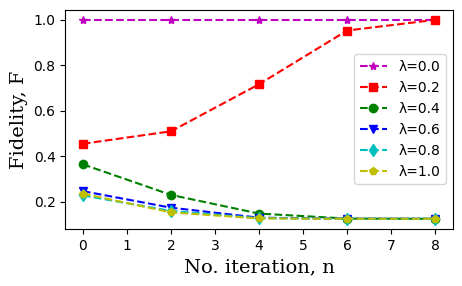

In [ ]:
xfont = {'fontname':'serif'}

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(iter_data[0::2], protocol_list[0][0::2], '*--m', label='λ=0.0')
ax.plot(iter_data[0::2], protocol_list[1][0::2], 's--r', label='λ=0.2')
ax.plot(iter_data[0::2], protocol_list[2][0::2], 'o--g', label='λ=0.4')
ax.plot(iter_data[0::2], protocol_list[3][0::2], 'v--b', label='λ=0.6')
ax.plot(iter_data[0::2], protocol_list[4][0::2], 'd--c', label='λ=0.8')
ax.plot(iter_data[0::2], protocol_list[5][0::2], 'p--y', label='λ=1.0')
ax.legend()
plt.xlabel('No. iteration, n', **xfont)
plt.ylabel('Fidelity, F', **xfont)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.subplots_adjust(bottom=0.15)
#fig.savefig('uniλ.pdf')
#files.download("uniλ.pdf")
plt.show()

In [ ]:
noq = 5
lam = 0.05
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)
rho_noisy = make_random_noisy_rho(rho_GHZ, noq, lam)

noi = 10  #No. iteration
iter_data = list(range(noi))
fid_data = [fidelity(uniform_scheme_g(rho_noisy, noq, i), GHZ) for i in range(noi)]

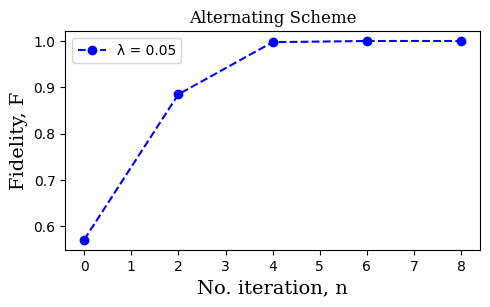

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(iter_data[0::2], fid_data[0::2], 'o--b', label=f'λ = {lam}')
plt.xlabel('No. iteration, n', fontname='serif')
plt.ylabel('Fidelity, F', fontname='serif')
plt.title('Uniform Scheme', fontname='serif')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## Block Metrics: Coherence vs. Population

To analyze how a quantum state ρ is distributed between the GHZ subspace \(P\) and its orthogonal complement \(Q\), we compute three quantities:


1. **Off-block coherence**  
 - Measures the coupling or coherence between the two subspaces.

 - Zero means perfectly block-diagonal (no leakage).

2. **Population in the GHZ block**
 - The weight of ρ inside the GHZ subspace.

3. **Population in the orthogonal block**
 - The weight outside the GHZ subspace.

In [23]:
noq = 3
d = 2**noq
lam = 0.1
GHZ = make_GHZ(noq)
rho_GHZ = make_rho_GHZ(GHZ)

In [33]:
def random_noise_in_GHZ_block(d, hermitian=True):
    """
    Generate a random matrix with non-zero entries only in the 2×2 GHZ block
    (indices 0 and d-1) of a d×d matrix.

    Parameters
    ----------
    d : int
        Dimension of the full Hilbert space (e.g., 2**nq).
    hermitian : bool, optional
        If True, symmetrize the matrix to make it Hermitian.

    """
    # Indices of the GHZ basis states in the computational basis
    inds = [0, d-1]

    # Start with a zero matrix
    N = np.zeros((d, d), dtype=complex)

    # Fill each (i, j) in the 2×2 GHZ block with an independent complex Gaussian random number
    for i in inds:
        for j in inds:
            N[i, j] = np.random.rand() + 1j * np.random.rand()

    # Optional: make it Hermitian by symmetrizing
    if hermitian:
        N = (N + N.conj().T) / 2

    return N

In [34]:
def random_noise_in_orthogonal_block(d, hermitian=True):
    """
    Generate a random matrix with entries in the orthogonal complement of the GHZ block.
    """
    # Indices of the GHZ basis states in the computational basis
    inds = {0, d-1}

    # Start with a zero matrix
    N = np.zeros((d, d), dtype=complex)

    # Fill every (i, j) not in the GHZ block with an independent complex Gaussian random number
    for i in range(d):
        for j in range(d):
            if not (i in inds and j in inds):
                N[i, j] = np.random.rand() + 1j * np.random.rand()

    # Optional: make it Hermitian by symmetrizing
    if hermitian:
        N = (N + N.conj().T) / 2

    return N

In [79]:
from scipy.linalg import ishermitian

Noise_GHZblock = random_noise_in_GHZ_block(d)
Noise_orthblock = random_noise_in_orthogonal_block(d)

ishermitian(Noise_GHZblock), ishermitian(Noise_orthblock)

(True, True)

In [35]:
def make_random_noisy_rho_ghzblock(rho_GHZ, nq, lambda_val):
  ''' Generate initial density matrix with noise only in the 2×2 GHZ block '''
  # lambda_val noise strength
  d = 2**nq # dimension
  rand_M = random_noise_in_GHZ_block(d)
  rho_noisy = rho_GHZ + lambda_val * rand_M
  return rho_noisy/np.trace(rho_noisy)

In [36]:
def make_random_noisy_rho_ortoblock(rho_GHZ, nq, lambda_val):
  ''' Generate initial density matrix with noise only in the orthogonal complement of the GHZ block '''
  # lambda_val noise strength
  d = 2**nq # dimension
  rand_M = random_noise_in_orthogonal_block(d)
  rho_noisy = rho_GHZ + lambda_val * rand_M
  return rho_noisy/np.trace(rho_noisy)

In [113]:
def make_random_ortoblock(nq):
  ''' Generate initial density matrix with noise only in the orthogonal complement of the GHZ block '''
  # lambda_val noise strength
  d = 2**nq # dimension
  rand_M = random_noise_in_orthogonal_block(d)
  #rand_M = rand_M @ rand_M    # if M is Hermitian, this is the same as M @ M.conj().T
  rho_noisy = rand_M
  return rho_noisy/np.trace(rho_noisy)

In [114]:
rho_noisy_ghzblock = make_random_noisy_rho_ghzblock(rho_GHZ, noq, lam)
rho_noisy_ortoblock = make_random_noisy_rho_ortoblock(rho_GHZ, noq, lam)
rho_random_ortoblock = make_random_ortoblock(noq)


np.trace(rho_random_ortoblock)

np.complex128(1+0j)

In [83]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

is_pos_def(rho_noisy_ghzblock), is_pos_def(rho_random_ortoblock)

(np.True_, np.True_)

In [39]:
noi = 10  #No. iteration
iter_data = list(range(noi))
fid_data_ghz = [fidelity(uniform_scheme_g(rho_noisy_ghzblock, noq, i), GHZ) for i in range(noi)]
fid_data_orto = [fidelity(uniform_scheme_g(rho_noisy_ortoblock, noq, i), GHZ) for i in range(noi)]
fid_data_rand_orto = [fidelity(uniform_scheme_g(rho_random_ortoblock, noq, i), GHZ) for i in range(noi)]

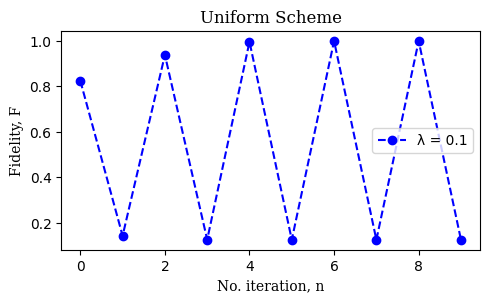

In [41]:
plt.figure(figsize=(5, 3))
plt.plot(iter_data[0::1], fid_data_orto[0::1], 'o--b', label=f'λ = {lam}')
plt.xlabel('No. iteration, n', fontname='serif')
plt.ylabel('Fidelity, F', fontname='serif')
plt.title('Uniform Scheme', fontname='serif')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

In [117]:
rho_iter = uniform_scheme_g(rho_random_ortoblock, noq, 10)

In [118]:
np.matrix.round(rho_iter, decimals=4)

array([[0.125-0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125-0.j,
        0.125+0.j, 0.125+0.j],
       [0.125-0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
        0.125+0.j, 0.125+0.j],
       [0.125-0.j, 0.125-0.j, 0.125-0.j, 0.125+0.j, 0.125-0.j, 0.125-0.j,
        0.125+0.j, 0.125-0.j],
       [0.125-0.j, 0.125-0.j, 0.125-0.j, 0.125+0.j, 0.125-0.j, 0.125-0.j,
        0.125+0.j, 0.125+0.j],
       [0.125-0.j, 0.125-0.j, 0.125+0.j, 0.125+0.j, 0.125-0.j, 0.125+0.j,
        0.125+0.j, 0.125+0.j],
       [0.125+0.j, 0.125-0.j, 0.125+0.j, 0.125+0.j, 0.125-0.j, 0.125-0.j,
        0.125+0.j, 0.125+0.j],
       [0.125-0.j, 0.125-0.j, 0.125-0.j, 0.125-0.j, 0.125-0.j, 0.125-0.j,
        0.125-0.j, 0.125+0.j],
       [0.125-0.j, 0.125-0.j, 0.125+0.j, 0.125-0.j, 0.125-0.j, 0.125-0.j,
        0.125-0.j, 0.125+0.j]])

In [52]:
P = np.outer(GHZ, GHZ.conj())  # |GHZ><GHZ|
Q = np.identity(2**noq) - P

In [54]:
rho_in = rho_noisy_ghzblock
rho_iter = uniform_scheme_g(rho_noisy_ghzblock, noq, 2)


ghzblock_in  = np.linalg.norm(P @ rho_in  @ P, ord='fro') #block of ρ entirely within the GHZ subspace
ortoblock_in  = np.linalg.norm(Q @ rho_in  @ Q, ord='fro') #block of ρ entirely within the orthogonal complement
#leakage or cross‐talk between your GHZ-like and ortogonal complement:
off_in  = np.linalg.norm(P @ rho_in  @ Q, ord='fro') + np.linalg.norm(Q @ rho_in  @ P, ord='fro') #the off-block couplings in the input state
off_out = np.linalg.norm(P @ rho_iter @ Q, ord='fro') + np.linalg.norm(Q @ rho_iter @ P, ord='fro') #the off-block couplings in the output state

#If off_in is zero but off_out > 0, the protocol introduced coupling.
#If off_out remains ≲ machine‐precision, the blocks stayed independent.

print(ghzblock_in, ortoblock_in, off_in, off_out)

0.9550352473954818 0.04496475260451771 0.038334627837067994 0.0034276322232491647


In [62]:
# population leaking — i.e. amplitude moving from the GHZ block into the orthogonal block
# In an ideal block‐preserving map, Tr[Pρ] stays 1 if it started in P, and Tr[Qρ] stays 0.
# If norm of the two off-diagonal blocks: off = 0, there’s no amplitude linking P and Q — they’re perfectly decoupled.

rho_in = rho_noisy_ghzblock
rho_iter = uniform_scheme_g(rho_noisy_ghzblock, noq, 2)

def block_leakage(ρ_out, P, Q):
    # off-block Frobenius norm
    off = (np.linalg.norm(P @ ρ_out @ Q, ord='fro')
         + np.linalg.norm(Q @ ρ_out @ P, ord='fro'))
    pop_leak = np.trace(Q @ ρ_out).real
    pop_P = np.trace(P @ ρ_out).real #ghz
    return off, pop_leak, pop_P

# Example run
off_in, pop_leak_in, pop_ghz_in  = block_leakage( rho_in, P, Q)
off_out, pop_leak_out, pop_ghz_out = block_leakage( rho_iter, P, Q)
print("Before: off-block=", off_in,  " pop-leakage=", pop_leak_in, " pop-GHZ=", pop_ghz_in)
print("After : off-block=", off_out, " pop-leakage=", pop_leak_out, " pop-GHZ=", pop_ghz_out)

Before: off-block= 0.038334627837067994  pop-leakage= 0.044964752604517925  pop-GHZ= 0.9550352473954821
After : off-block= 0.0034276322232491647  pop-leakage= 0.008887758645944127  pop-GHZ= 0.9911122413540558


In [77]:
# initial state entirely in the orthogonal subspace — ρ_in=QρQ,PρP=0
# ideal case no off-block coherence: PρQ=QρP=0 for both in and out state
# Population stays in the orthogonal block: Tr(Qρ)=1,Tr(Pρ)=0, for both in and out state

rho_in = rho_random_ortoblock
rho_iter = uniform_scheme_g(rho_random_ortoblock, noq, 2)

#Example run
off_in, pop_leak_in, pop_ghz_in  = block_leakage(rho_in, P, Q)
off_out, pop_leak_out, pop_ghz_out = block_leakage( rho_iter, P, Q)
print("Before: off-block=", off_in,  " pop-leakage=", pop_leak_in, " pop-GHZ=", pop_ghz_in)
print("After : off-block=", off_out, " pop-leakage=", pop_leak_out, " pop-GHZ=", pop_ghz_out)

Before: off-block= 0.5863593795106637  pop-leakage= 0.8176671002555549  pop-GHZ= 0.1823328997444451
After : off-block= 0.8198010196291743  pop-leakage= 0.7391412590912124  pop-GHZ= 0.26085874090878747
